# Sports Detector
## Curso Deep Learning y Cuda
### Trabajo Voluntario - Fundamentals Of Deep Learning for Computer Vision
#### Autor: Oscar Noel Amaya Garcia   
#### email: dbanshee@gmail.com

Esta práctica voluntaria pretende complementar bajando un peldaño en la abstracción del desarrollo de una red neuronal convolucional respecto a la vista durante la asignatura haciendo uso de **DIGITS**. Se procesará manualmente un **dataset** público y se aplicarán algunas de las librerías actuales mas utilizadas para la generación de conjuntos de pruebas, procesado de imagenes y se implementará una red neuronal mediante el framework **Keras**. Finalmente se simulará la puesta en producción cargando el modelo y sus pesos préviamente exportado y enfrentándolo a una prueba real de detección sobre una imágen pública tomada de internet.

In [ ]:
# Dependencias
!pip install wget
!pip install tensorflow
!pip install opencv-python

## Dataset

Se ha elegido un dataset público de deportes de la **Universidad de Stanford** \
**Url**: http://vision.stanford.edu/lijiali/event_dataset/

El dataset consiste en un conjunto de imágenes de deportes clasificadas en carpetas con el nombre del deporte correspondiente.
Se aplica un redimensionado de las imágenes a un tamaño de *150x150* para hacer este proyecto viable en el hardware del que se dispone.

In [ ]:
# Download Dataset
import wget
import os

DATASET_FILENAME = 'dataset.rar'

if not os.path.exists(DATASET_FILENAME):
    url = 'http://vision.stanford.edu/lijiali/event_dataset/event_dataset.rar'
    print('Downloading dataset ... ')
    wget.download(url, DATASET_FILENAME)
    print('Download completed ')

# Extract
!unrar x {DATASET_FILENAME} # Revisar este comando

### Procesado Dataset

Se recorre el árbol de directorios del *dataset*, y se almacena en un diccionario *Python* cuya clave es el nombre del deporte en que se clasifica cada imagen.

Adicionalmente se aplica un **reescalado** de las imágenes a **150x150** pixeles para unificando todo el conjunto.

Libreria para procesado de imagenes: **opencv**

In [13]:
import os
import re
import cv2

DIR_IMAGES='./event_img'
IMAGE_LIMIT=None
IMAGE_RESIZE_DIM = (150, 150)

def resizeImage(path, heigth, width):
    image = cv2.imread(path)
    image = cv2.resize(image, dsize=(heigth, width), interpolation=cv2.INTER_CUBIC)
    return image

def processDataset(path, limit=None):
    dirname = os.path.join(os.getcwd(), DIR_IMAGES)
    imgpath = dirname + os.sep

    mImgDir = dict()
    cnt = 0
    
    print("Dataset Directory : {} ...".format(imgpath))
    for root, dirnames, filenames in os.walk(imgpath):
        for filename in filenames:
            if limit != None and cnt >= limit:
                break

            if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
                filepath = os.path.join(root, filename)
                splitFileName = root.split(os.sep)
                name = splitFileName[-1]
                curImgList = mImgDir.get(name)
                if curImgList is None:
                    curImgList = []
                    mImgDir[name] = curImgList

                curImgList.append(resizeImage(filepath, IMAGE_RESIZE_DIM[0], IMAGE_RESIZE_DIM[1]))
                cnt += 1
    return mImgDir


# Process Dataset
IMG_DATASET = processDataset(DIR_IMAGES, IMAGE_LIMIT)

imgCnt = 0
print("Image Summary:\n")
for key, value in IMG_DATASET.items():
    print('  [{}] -> {}'.format(key, len(value)))
    imgCnt += len(value)
print("\nTotal Images: {}".format(imgCnt))

Dataset Directory : /home/banshee/./event_img/ ...
Image Summary:

  [bocce] -> 137
  [croquet] -> 235
  [rowing] -> 250
  [badminton] -> 198
  [sailing] -> 189
  [polo] -> 181
  [RockClimbing] -> 194
  [snowboarding] -> 190

Total Images: 1574


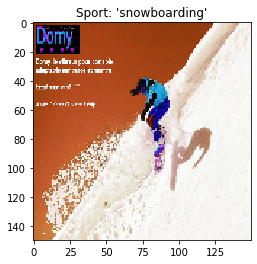

In [14]:
# Print Sample
import matplotlib.pyplot as plt

for key, value in IMG_DATASET.items():
    plt.imshow(value[0])
    plt.title("Sport: '{}'".format(key))

### Normalización de Datos

Se normalizan los datos y se generan etiquetas numéricas para cada clase, dando como resultado los arrays **X** e **y** correspondientes al conjunto de todas las imágenes y su clase correspondiente.

Se modifica el rango numérico de las imágenes del intervalo *[0,255] Integer* a, *[0,1] Float*  para su posterior procesado en la red neuronal convolucional.

In [15]:
import numpy as np

nlabel = 0
labels = {}

def normalizeImages(imgs):
    imgs = imgs.astype('float32')
    imgs = imgs / 255.
    return imgs

X = []
y = []
for key, value in IMG_DATASET.items():
    labels[nlabel] = key
    X.extend(value)
    y.extend((np.ones(len(value)) * nlabel) .astype(int).tolist())
    nlabel += 1

numLabels = len(IMG_DATASET.keys())

X = np.array(X, dtype=np.uint32)
y = np.array(y, dtype=np.uint32)

print("X shape : {}".format(X.shape))
print("y shape : {}".format(y.shape))

X = normalizeImages(X)

X shape : (1574, 150, 150, 3)
y shape : (1574,)


## Conjunto Entrenamiento y Test

Para entrenar correctamente la red es necesario mezclar los datos de manera homogénea y dividirlos en los conjuntos de entrenamiento y test. Para ello nos apoyamos en la librería: \
**SciKit Learn** : <https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html>

Especificaremos el porcentaje del *dataset* que emplearemos para test mediante el argumento **test_size**. En este caso un **80%** para entrenamiento y el **20%** para test.

In [16]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

print("train_X shape: {}, train_y shape: {}".format(train_X.shape, train_y.shape))
print("test_X  shape: {}, test_y shape: {}".format(test_X.shape, test_y.shape))

train_X shape: (1259, 150, 150, 3), train_y shape: (1259,)
test_X  shape: (315, 150, 150, 3), test_y shape: (315,)


### One hot encoding

Se genera la representacion **One Hot Encoding** para los arrays de etiquetas del conjunto de datos. Esta respresentacion es idónea para casar las predicciones deseadas en la capa de salida de nuestra red.

Información general:
- [Wikipedia One Hot](https://es.wikipedia.org/wiki/One-hot)
- [What is one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)

Para ello nos apoyamos en el paquete *utils* de la libreria **Keras**: \
<https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical>

In [17]:
from keras.utils import to_categorical

train_y_one_hot = to_categorical(train_y)
test_y_one_hot = to_categorical(test_y)

print("train_y_one_hot shape: {}".format(train_y_one_hot.shape))
print("test_y_one_hot shape: {}".format(test_y_one_hot.shape))

train_y_one_hot shape: (1259, 8)
test_y_one_hot shape: (315, 8)


## Red Neuronal Convolucional en **Keras**

**Keras** es uno de los frameworks de alto nivel disponibles para diseñar redes neuronales. Abstrae la implementación sobre otras librerías de mas bajo nivel como **TensorFlow** o **Caffe**. A partir de la versión **2.0** de *TensorFlow*, *Keras* ha pasado a ser una librería integrada en *TF*.

Las redes en *Keras* se diseñan con muy poco código, resultando en redes muy legibles. Si se desea un control mas fino de la arquitectura es posible obtener su equivalente en **TensorFlow** y proceder al nivel de detalle deseado.

Un buen recurso para entender la diferencia entre ambas es: [DotCSV 3 Maneras de diseñar una Red Neuronal](https://www.youtube.com/watch?v=qTNUbPkR2ao)

### Modelo

Se plantea un modelo de Red Neuronal Convolucional basado en las siguientes características.

- Capa 1: Capa **Convolucional** con 32 *kernels* de tamaño **3x3** y tamaño de entrada **120x120**.
- Capa 2: Capa de Activación **LeakyRelu** [Keras LeakyRelu Layer](https://keras.io/layers/advanced-activations/), [Funciones de Activacion](https://medium.com/@himanshuxd/activation-functions-sigmoid-relu-leaky-relu-and-softmax-basics-for-neural-networks-and-deep-8d9c70eed91e) 
- Capa 3: Capa **MaxPooling** para reducir el tamaño de las imágenes generadas en la capa convolucional a la mitad.
- Capa 4: Capa **Dropout**. Elimina parte de las neuronas. Esto intenta evitar la aparición de *overfitting*.
- Capas 5,6,7: Repiten las características de las capas anteriores, incrementando la abstracción de los conocimientos adquiridos en las capas anteriores, preservando el conocimiento.
- Capas 8,9,10: Idem.
- Capa 11: Capa **Flatten** Se aplana la salida de la capa anterior.
- Capa 12: Capa **Dense**: Capa de neuronas tradicional.
- Capa 13: Capa **Dense** de salida con función de activación **softmax** para devolver la probabilidad de cada clase. Esta capa tendrá tantas neuronas como clases diferentes tenga el dataset.

In [31]:
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='linear', padding='same', input_shape=(150, 150, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2,2), padding='same'))
model.add(Dropout(0.5))

model.add(Conv2D(32, kernel_size=(3, 3), activation='linear', padding='same', input_shape=(75, 75, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2,2), padding='same'))

model.add(Conv2D(32, kernel_size=(3, 3), activation='linear', padding='same', input_shape=(37, 37, 3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2,2), padding='same'))

model.add(Flatten())
model.add(Dense(32, activation='linear'))
model.add(Dense(numLabels, activation='softmax'))

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 150, 150, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 75, 75, 32)        9248      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 75, 75, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 38, 38, 32)       

### Callbacks y Compilacion del modelo

*Keras* permite la definición de *callbacks* que serán invocadas durante el entrenamiento de la red al término de cada *epoch*. De este modo se puede interactuar y comprender mejor el modelo para su posterior optimización.

Se define aquí una función para la representación de las 4 funciones básicas [**train_loss**, **train_acc**, **test_loss**, **train_acc**] mediante la librería gráfica **matplotlib**.

Se compila el modelo utilizando el optimizador **Adagrad**. Este optimizador mantiene un *learning rate* individual para cada peso, y lo modifica teniendo en cuenta el gradiente del error en iteraciones pasadas. Como consecuencia el consumo de memoria de este optimizador es elevado. [Tipos de Optimizadores](https://towardsdatascience.com/types-of-optimization-algorithms-used-in-neural-networks-and-ways-to-optimize-gradient-95ae5d39529f)

La función de coste elegida es la **Categorical Crossentropy**. Esta función mide como de diferente es en esencia un tensor de otro dado. Suele utilizarse en problemas de clasificación cuando una muestra pertenece a una clase de manera excluyente con las otras. [Keras Loss Functions](https://towardsdatascience.com/a-guide-to-neural-network-loss-functions-with-applications-in-keras-3a3baa9f71c5)

In [19]:
import keras
from IPython.display import clear_output

# Keras callback
class TrainingPlot(keras.callbacks.Callback):
    
    def __init__(self, model):
        self.model = model

    def on_train_begin(self, logs={}):
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_accuracy'))

        if len(self.losses) > 1: # at least 2 epochs
            clear_output(wait=True) # Clear the previous plot
            
            N = np.arange(0, len(self.losses))
            
            #plt.style.use("seaborn")
            plt.figure(figsize=(15, 5))
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(epoch))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.autoscale()                
            plt.show()

In [35]:
# Initial Parameters
init_lr = 1e-3   
epochs = 100    
batch_size = 32 

# Compilacion del modelo
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adagrad(lr=init_lr, decay=init_lr / 100), metrics=['accuracy'])

### Entrenamiento

Se realiza el entrenamiento sobre el siguiente sistema:

- **GPU**: nVidia GTX 760 - 2GB GDDR5
- **CPU**: Intel(R) Core(TM) i5-3570K CPU @ 3.40GHz
- **Memoria**: 16GB DDR3
- **SO**: Kubuntu 19.10

Aquí es donde se produce la **magia** y tiene lugar *Cuda*. En las librerías que realizan el entrenamiento y la inferencia sobre redes neuronales.
Los frameworks como *Caffe*, *TensorFlow*, *PyTorch* y otros, son compilados haciendo uso de las librerías de *nVidia Cuda*. La naturaleza de estas redes encaja perfectamente en el tipo de procesamiento paralelo que para las que ha sido ideado.

Para el caso particular de la *GPU* sobre la que se ha desarrollado esta práctica ha sido necesario [compilar a partir del código fuente] (https://www.tensorflow.org/install/source) *TensorFlow* (toda una aventura en si misma) ya que para versiones recientes, las distribuciones en los repositorios están compiladas asumiendo valores de *Compute Capability* mayores a 3.0, versión máxima para la **GTX 760**, haciendo ésta incompatible.

Existen repositorios en *GitHub* con precompilados de diversas versiones para ahorrar este trabajo a usuarios con diferentes configuraciones hardware.
- https://github.com/evdcush/TensorFlow-wheels
- https://github.com/fo40225/tensorflow-windows-wheel

Un recurso muy útil pero ninguna se adaptaba a mis necesidades de *CPU-GPU*.

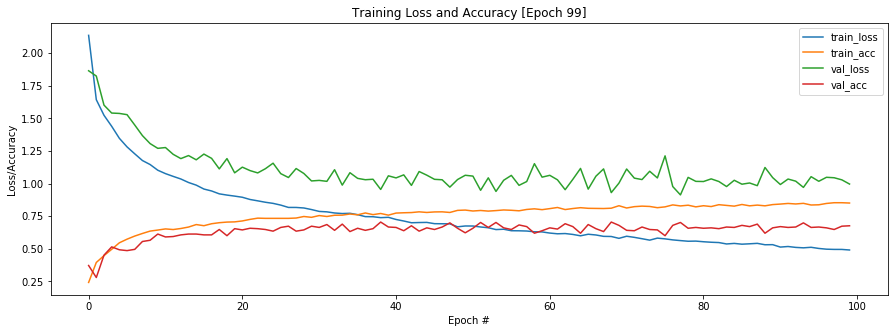

Train loss: 0.49041501511364727
Train accuracy: 0.85067517


In [36]:
plot_losses = TrainingPlot(model=model)

try:
    train = model.fit(train_X, train_y_one_hot, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(test_X, test_y_one_hot), callbacks=[plot_losses])

    print('Train loss:', train.history['loss'][-1])
    print('Train accuracy:', train.history['accuracy'][-1])
except KeyboardInterrupt:
    None
    
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
model.save("sports_mnist.h5py")

### Exportacion de la red

In [23]:
SAVEMODEL_FILENAME = 'model.h5py' 
model.save(SAVEMODEL_FILENAME)
print('Model Saved to file: {}'.format(SAVEMODEL_FILENAME))

Model Saved to file: model.h5py


### Evaluación de la red

Se realiza la evaluación del conjunto reservado para test. Debido a la simplicidad de la red, el porcentaje de aciertos no es abrumador, pero tampoco es el objetivo de este cuaderno. Una red neuronal para una precisión mas elevada puede requierir de mayor complejidad en su arquitectura y un dataset mas amplio. No obstante podrían conseguirse mejores resultados explorando a través de los *hyperparametros* y algunas modificaciones simples sobre el modelo.

In [24]:
predictions = model.predict(test_X)

predicted_sport=[]
for p in predictions:
    predicted_sport.append(p.tolist().index(max(p)))
predicted_sport=np.array(predicted_sport)

Correct Detections : 163


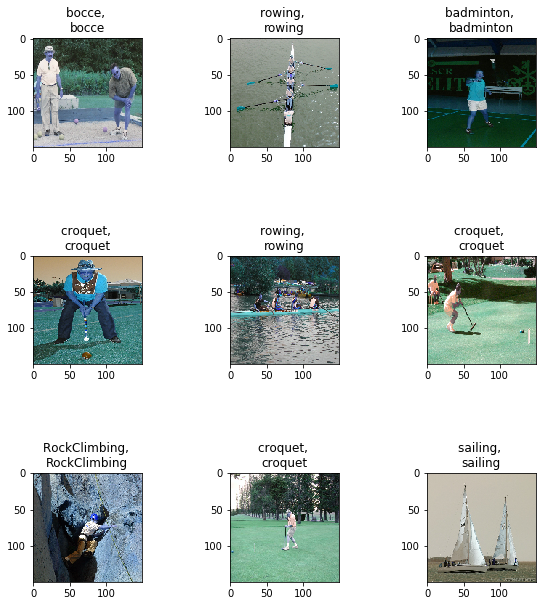

In [25]:
correct = np.where(predicted_sport==test_y)[0]
print("Correct Detections : {}".format(len(correct)))

plt.figure(figsize=(10, 10))
if len(correct) > 0:
    for i, icorrect in enumerate(correct[0:9]):
        plt.subplot(3,3,i+1)
        plt.subplots_adjust(hspace=1)
        plt.imshow(test_X[icorrect], cmap='gray', interpolation='none')
        plt.imshow(test_X[icorrect], cmap='gray', interpolation='none')
        plt.title("{}, \n{}".format(labels[predicted_sport[icorrect]], labels[test_y[icorrect]]))

Incorrect Detections : 152


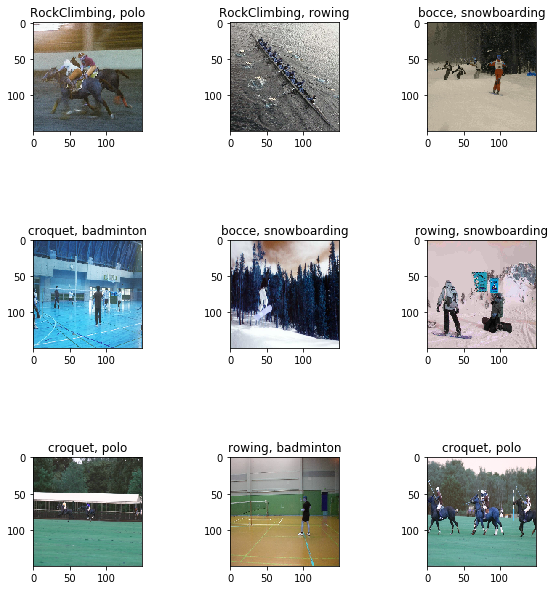

In [26]:
incorrect = np.where(predicted_sport!=test_y)[0]
print("Incorrect Detections : {}".format(len(incorrect)))

plt.figure(figsize=(10, 10))
if len(incorrect) > 0:
    for i, iincorrect in enumerate(incorrect[0:9]):
        plt.subplot(3,3,i+1)
        plt.subplots_adjust(hspace=1)
        plt.imshow(test_X[iincorrect], cmap='gray', interpolation='none')
        plt.title("{}, {}".format(labels[predicted_sport[iincorrect]], labels[test_y[iincorrect]]))

### Carga y Test

Una vez entrenada la red, es posible cargar el modelo y sus pesos para realizar inferencias. [Keras Save Model](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) \
El siguiente código, inicializará la red neuronal convolucional previamente entrenada y permitirá descargar una imágen a tráves de una URL tratando de predecir el deporte representado en la imagen.

In [32]:
from keras.models import load_model

SAVEMODEL_FILENAME = 'model.h5py' 
loadedModel = load_model(SAVEMODEL_FILENAME)
print('Model Loaded from filename : {}'.format(SAVEMODEL_FILENAME))

Model Loaded from filename : model.h5py


Image corresponds to sport: [badminton]


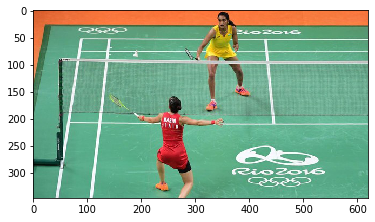

In [33]:
import wget

IMAGE_RESIZE_DIM = (150, 150)
TMP_FILE = 'tmp_image.jpg'
IMAGE_URL = 'https://static1.abc.es/media/deportes/2018/08/04/marin-sindhu-kv0C--620x349@abc.jpg'

# Download Image
!rm -rf {TMP_FILE}
wget.download(IMAGE_URL, TMP_FILE)

# Preview
preview = plt.imread(TMP_FILE)
plt.imshow(preview)

# Prepare Image to CVNN
image = resizeImage(TMP_FILE, IMAGE_RESIZE_DIM[0], IMAGE_RESIZE_DIM[1])
image = normalizeImages(image)
model_entry = np.array([image])

# Make prediccion
prediction = loadedModel.predict(model_entry)
prediction = prediction[0].tolist().index(max(prediction[0]))
predictionLabel = labels[prediction]

# Print Predicted Sport
print("Image corresponds to sport: [{}]".format(predictionLabel))

## Conlusiones

En este cuaderno se ha realizado el viaje completo sobre una aplicacion práctica en **Deep Learning for Computer Vision**, desde el la obtención del dataset, su procesamiento, definicion del modelo, entrenmiento y explotación del mismo lo cual da una visión mas cercana al desarrollador con herramientas actuales que complementan lo visto en clase. Destacar que **DIGITS** sigue siendo una gran herramienta para pruebas de concepto, automatización, y entrenamiento en la nube.